# Porto Seguro - A Second Submission.

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns

from sklearn.metrics import roc_auc_score
#import joypy
import re
#from IPython.display import display, HTML
#import ipywidgets as widgets # for later


pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 12,\
   'axes.titlesize': 12, 'font.size': 12, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 12,\
   'xtick.labelsize': 12, 'ytick.labelsize': 12}

sns.set(style="darkgrid", color_codes=True,rc=rc)

In [108]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.replace(to_replace=-1,value=-999,inplace=True) # replace value for nan
test.replace(to_replace=-1,value=-999,inplace=True) # replace value for nan

In [109]:
def MetaDataTypes(df,types_var=['cat','bin','target']):
    # Classifying the variables in the data
    variables = []
    vartype = {}
    for variable in df.columns:
        for types in types_var:
            ty = "None"
            if df[variable].dtype == int:
                tybin = "ordinal"
            elif df[variable].dtype == float:
                tybin = "continuous"
            match = re.search('^.*'+types+'.*$',variable)
            if match:
                ty = types
                if re.search('^.*bin.*$',variable):
                    tybin='binary'
                if re.search('^.*cat.*$',variable):
                    tybin='categorical'
                if 'target' in variable:
                    tybin = 'binary'
                break

            
        variables.append([variable,ty,tybin])
        
    variablesdf = pd.DataFrame(variables,columns=['name','type','bin'])
    
    for i in ['ordinal','continuous','binary','categorical']:
        vartype[i]=variablesdf.name[(variablesdf.bin==i)]

    # Creating dataframe containing variables
    return variablesdf,vartype

In [110]:
types_var = ['ind','reg','car', 'calc','target','id']
variablesdf,vartype = MetaDataTypes(train,types_var)

## Transforming categorical variables

### 1. One-Hot Enconding for some Categorical Variables

In [111]:
# My own function - It is less efficient

def Create_OHE(dataframe,variables,limit):
    df = dataframe.copy()
    for variable in variables:
        if len(pd.unique(df[variable])) < limit and len(pd.unique(df[variable])) > 2:
            columnsv = [variable + '_ohe' + str(value) for value in pd.unique(df[variable]).tolist()]
            dummy = pd.get_dummies(df[variable])
            dummy.columns = columnsv
            df = df.drop(variable,axis=1).copy().join(dummy)
            #print(variable,columnsv)
            
        else:
            pass
    return df

In [112]:
train_ohe = Create_OHE(train,vartype['categorical'].values,6)
#Create_OHE(traindrop,traindrop.columns,5)

In [113]:
test_ohe = Create_OHE(test,vartype['categorical'].values,6)

### 3. Cross-Validation

In [116]:
# Code from https://github.com/felipeeeantunes/udacity_live
# The comments are mine
def cross_val_model(X,y, model, n_splits=3):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score
    X = np.array(X)
    y = np.array(y)


    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))
    # folds are a list of the indexes that were divided in the training subsection and the hold-out.

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx] #train_idx are the indexes of the training subset
        y_train = y[train_idx] 
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())
    model.fit(X_train, y_train)

### XGBoost

In [117]:
from xgboost import XGBClassifier

In [118]:
# XGBoost params
''' Initial
xgb_params = {}
xgb_params['learning_rate'] = 0.02
xgb_params['n_estimators'] = 200
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.8
xgb_params['colsample_bytree'] = 0.8
'''
xgb_params = {}
xgb_params['missing'] = -999
xgb_params['learning_rate'] = 0.2
# xgb_params['learning_rate'] = 0.012983377237040745
xgb_params['n_estimators'] = 75
# xgb_params['n_estimators'] = 750
xgb_params['max_depth'] = 6
xgb_params['reg_alpha'] = 6.037927795611329e-05
xgb_params['reg_lambda'] = 7.3327894939712616e-06
xgb_params['colsample_bytree'] = 0.6013536865241922 
xgb_params['min_child_weight'] = 0.6020963925048413

In [119]:
XGB_model = XGBClassifier(**xgb_params)

In [120]:
X = train.drop('target',axis=1)
y = train['target']

In [121]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.57508
Fit XGBClassifier fold 2
    cross_score: 0.53848
Fit XGBClassifier fold 3
    cross_score: 0.54108


In [89]:
X = np.array(X)
y = np.array(y)
XGB_model.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.6013536865241922, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=6, min_child_weight=0.6020963925048413,
       missing=None, n_estimators=75, nthread=-1,
       objective='binary:logistic', reg_alpha=6.037927795611329e-05,
       reg_lambda=7.3327894939712616e-06, scale_pos_weight=1, seed=0,
       silent=True, subsample=1)

In [90]:
yscores = XGB_model.predict_proba(np.array(X))[:,1]
results = pd.DataFrame(data=yscores,columns=['score'])
results['target'] = y
results['targetpredict'] = results.score.apply(lambda x: 0 if x<0.1 else 1)

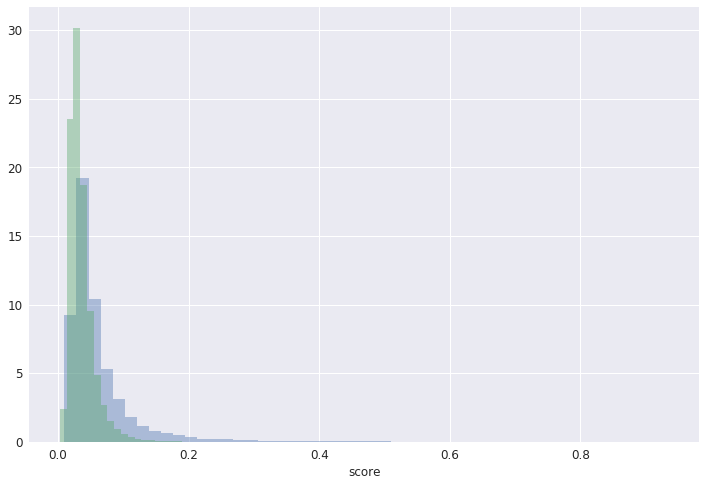

In [91]:
sns.distplot(results.score[results.target == 1],norm_hist=True,kde=False)
sns.distplot(results.score[results.target == 0],norm_hist=True,kde=False)

In [92]:
from sklearn.metrics import roc_curve

In [93]:
fpr, tpr, thresholds  = roc_curve(y,yscores)


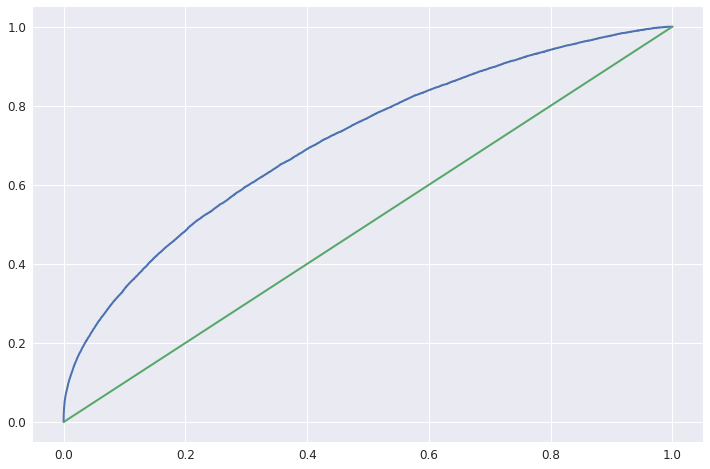

In [103]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])